### 1. Review of model evaluationm
- Need a way to choose between models: different model types, tuning parameters, and features
- Use a model evaluation procedure to estimate how well a model will generalize to out-of-sample data
- Requires a model evaluation metric to quantify the model performance

### 2. Model evaluation procedures
__Training and testing on the same data__
- Rewards overly complex models that "overfit" the training data and won't necessarily generalize

__Train/test split__
- Split the dataset into two pieces, so that the model can be trained and tested on different data
- Better estimate of out-of-sample performance, but still a "high variance" estimate
- Useful due to its speed, simplicity, and flexibility

__K-fold cross-validation__
- Systematically create "K" train/test splits and average the results together
- Even better estimate of out-of-sample performance
- Runs "K" times slower than train/test split

### 3. Model evaluation metricsm
__Regression problems:__ Mean Absolute Error, Mean Squared Error, Root Mean Squared Error

__Classification problems:__ Classification accuracy
- There are many more metrics, and we will discuss them today

### 4. Classification accuracy

In [1]:
#importing the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
# import data
data = pd.read_csv('Fraud_check.csv')
data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
categorical_col = []

for column in data.columns:
    if data[column].dtype == object:
        categorical_col.append(column)
        print(f"{column} : {data[column].unique()}")
        print("------------------------------------")
        print(f"{column} : {data[column].value_counts()}")
        print("====================================\n\n")

Undergrad : ['NO' 'YES']
------------------------------------
Undergrad : YES    312
NO     288
Name: Undergrad, dtype: int64


Marital.Status : ['Single' 'Divorced' 'Married']
------------------------------------
Marital.Status : Single      217
Married     194
Divorced    189
Name: Marital.Status, dtype: int64


Urban : ['YES' 'NO']
------------------------------------
Urban : YES    302
NO     298
Name: Urban, dtype: int64




In [4]:
from sklearn.preprocessing import LabelEncoder

# risk = 1 and good = 0
data['Result'] = data['Taxable.Income'].apply(lambda value: 1 if value <= 30000 else 0)
label = LabelEncoder()
for column in categorical_col:
    data[column] = label.fit_transform(data[column])
data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Result
0,0,2,68833,50047,10,1,0
1,1,0,33700,134075,18,1,0
2,0,1,36925,160205,30,1,0
3,1,2,50190,193264,15,1,0
4,0,1,81002,27533,28,0,0


In [5]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X = data.drop('Result', axis=1)
y = data.Result

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 120)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((450, 6), (450,), (150, 6), (150,))

In [6]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

LogisticRegression()

In [7]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

__Classification accuracy:__ percentage of correct predictions

In [8]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.9066666666666666


__Null accuracy:__ accuracy that could be achieved by always predicting the most frequent class
- We must always compare with this

In [9]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    115
1     35
Name: Result, dtype: int64

In [10]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
y_test.mean()

0.23333333333333334

In [11]:
# calculate the percentage of zeros
1 - y_test.mean()

0.7666666666666666

In [12]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.7666666666666666

In [13]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.766667
Name: Result, dtype: float64

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       115
           1       0.89      0.69      0.77        35

    accuracy                           0.91       150
   macro avg       0.90      0.83      0.86       150
weighted avg       0.91      0.91      0.90       150



Comparing the __true__ and __predicted__ response values

In [15]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('False:', y_pred_class[0:25])

True: [0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0]
False: [0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0]


__Conclusion:__

- Classification accuracy is the easiest classification metric to understand
- But, it does not tell you the underlying distribution of response values
- We examine by calculating the null accuracy
- And, it does not tell you what "types" of errors your classifier is making

### 5. Confusion matrix

In [16]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[112   3]
 [ 11  24]]


__Basic terminology:__

- __True Positives (TP):__ we correctly predicted that they do have diabetes
        112

- __True Negatives (TN):__ we correctly predicted that they don't have diabetes
        24

- __False Positives (FP):__ we incorrectly predicted that they do have diabetes (a "Type I error")
        3
        -Falsely predict positive
        -Type I error

- __False Negatives (FN):__ we incorrectly predicted that they don't have diabetes (a "Type II error")
        11
        -Falsely predict negative
        -Type II error

In [17]:
# print the first 25 true and predicted responses
print('True', y_test.values[0:25])
print('Pred', y_pred_class[0:25])

True [0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0]
Pred [0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0]


In [18]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[112   3]
 [ 11  24]]


### 6. Metrics computed from a confusion matrix

__Classification Accuracy:__ Overall, how often is the classifier correct?

In [19]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.9066666666666666
0.9066666666666666


__Classification Error:__ Overall, how often is the classifier incorrect?

- Also known as "Misclassification Rate"

In [20]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.09333333333333334
0.09333333333333338


__Sensitivity:__Sensitivity When the actual value is positive, how often is the prediction correct?

- Something we want to maximize
- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"
- TP / all positive
- all positive = TP + FN

In [21]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.6857142857142857
0.6857142857142857


__Specificity:__ When the actual value is negative, how often is the prediction correct?

- Something we want to maximize
- How "specific" (or "selective") is the classifier in predicting positive instances?
- TN / all negative
- all negative = TN + FP

In [22]:
specificity = TN / (TN + FP)

print(specificity)

0.9739130434782609


__False Positive Rate:__ When the actual value is negative, how often is the prediction incorrect?

In [23]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.02608695652173913
0.02608695652173909


__Precision:__ When a positive value is predicted, how often is the prediction correct?

In [24]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.8888888888888888
0.8888888888888888


__Which metrics should you focus on?__

- Choice of metric depends on your business objective
- Identify if FP or FN is more important to reduce
- Choose metric with relevant variable (FP or FN in the equation)

__Spam filter__ (positive class is "spam"):
- Optimize for precision or specificity
        precision
        false positive as variable
- specificity
        false positive as variable
- Because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)


__Fraudulent transaction detector__ (positive class is "fraud"):
- Optimize for sensitivity
        FN as a variable
- Because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

### 7. Adjusting the classification threshold

In [25]:
# print the first 10 predicted responses
# 1D array (vector) of binary values (0, 1)
logreg.predict(X_test)[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [26]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10]

array([[9.99980451e-01, 1.95485497e-05],
       [9.99996586e-01, 3.41408613e-06],
       [4.71655660e-01, 5.28344340e-01],
       [7.87998863e-01, 2.12001137e-01],
       [7.67008288e-01, 2.32991712e-01],
       [9.98402458e-01, 1.59754241e-03],
       [9.92681443e-01, 7.31855745e-03],
       [9.99736428e-01, 2.63572279e-04],
       [9.90233484e-01, 9.76651600e-03],
       [1.00277351e-01, 8.99722649e-01]])

- predict_proba process
        1. Predicts the probabilities
        2. Choose the lass with the highest probability
- There is a 0.5 classification threshold
        1. Class 1 is predicted if probability > 0.5
        2. Class 0 is predicted if probability < 0.5

In [27]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([1.95485497e-05, 3.41408613e-06, 5.28344340e-01, 2.12001137e-01,
       2.32991712e-01, 1.59754241e-03, 7.31855745e-03, 2.63572279e-04,
       9.76651600e-03, 8.99722649e-01])

In [28]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [29]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12

Text(0, 0.5, 'Frequency')

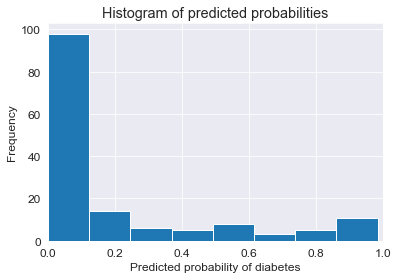

In [30]:
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

__Observations:__
We can see from the first bar
- About 93% of observations have probability from 0.001 to 0.100
- Small number of observations with probability > 0.5
- This is below the threshold of 0.5

__Solution:__
- Decrease the threshold value
- Increase the sensitivity of the classifier
        This would increase the number of TP
        More sensitive to positive instances


In [31]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([1.95485497e-05, 3.41408613e-06, 5.28344340e-01, 2.12001137e-01,
       2.32991712e-01, 1.59754241e-03, 7.31855745e-03, 2.63572279e-04,
       9.76651600e-03, 8.99722649e-01])

In [32]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [35]:
y_pred_probs = y_pred_prob.reshape(-1, 1)

# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_probs, 0.3)[0]

C:\Users\KUNAL\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [36]:
# print the first 10 predicted probabilities
y_pred_probs[0:10]

array([[1.95485497e-05],
       [3.41408613e-06],
       [5.28344340e-01],
       [2.12001137e-01],
       [2.32991712e-01],
       [1.59754241e-03],
       [7.31855745e-03],
       [2.63572279e-04],
       [9.76651600e-03],
       [8.99722649e-01]])

In [41]:
y_pred_prob = logreg.predict_proba(X_test)[0:10]

y_pred_prob

array([[9.99980451e-01, 1.95485497e-05],
       [9.99996586e-01, 3.41408613e-06],
       [4.71655660e-01, 5.28344340e-01],
       [7.87998863e-01, 2.12001137e-01],
       [7.67008288e-01, 2.32991712e-01],
       [9.98402458e-01, 1.59754241e-03],
       [9.92681443e-01, 7.31855745e-03],
       [9.99736428e-01, 2.63572279e-04],
       [9.90233484e-01, 9.76651600e-03],
       [1.00277351e-01, 8.99722649e-01]])

In [42]:
# print the first 10 predicted probabilities for class 1 - Probability of rain

logreg.predict_proba(X_test)[0:10, 1]

array([1.95485497e-05, 3.41408613e-06, 5.28344340e-01, 2.12001137e-01,
       2.32991712e-01, 1.59754241e-03, 7.31855745e-03, 2.63572279e-04,
       9.76651600e-03, 8.99722649e-01])

In [43]:
# store the predicted probabilities for class 1 - Probability of rain

y_pred1 = logreg.predict_proba(X_test)[:, 1]

In [45]:
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score

for i in range(1,5):
    
    cm1=0
    
    y_pred1 = logreg.predict_proba(X_test)[:,1]
    
    y_pred1 = y_pred1.reshape(-1,1)
    
    y_pred2 = binarize(y_pred1, i/10)
    
    #y_pred2 = np.where(y_pred2 == 1, 'Yes', 'No')
    
    cm1 = confusion_matrix(y_test, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
           
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
            cm1[0,1],'Type I errors( False Positives), ','\n\n',
           
            cm1[1,0],'Type II errors( False Negatives), ','\n\n',
           
           'Accuracy score: ', (accuracy_score(y_test, y_pred2)), '\n\n',
           
           'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',
           
           'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[96 19]
 [ 0 35]] 

 with 131 correct predictions,  

 19 Type I errors( False Positives),  

 0 Type II errors( False Negatives),  

 Accuracy score:  0.8733333333333333 

 Sensitivity:  1.0 

 Specificity:  0.8347826086956521 



With 0.2 threshold the Confusion Matrix is  

 [[103  12]
 [  2  33]] 

 with 136 correct predictions,  

 12 Type I errors( False Positives),  

 2 Type II errors( False Negatives),  

 Accuracy score:  0.9066666666666666 

 Sensitivity:  0.9428571428571428 

 Specificity:  0.8956521739130435 



With 0.3 threshold the Confusion Matrix is  

 [[108   7]
 [  5  30]] 

 with 138 correct predictions,  

 7 Type I errors( False Positives),  

 5 Type II errors( False Negatives),  

 Accuracy score:  0.92 

 Sensitivity:  0.8571428571428571 

 Specificity:  0.9391304347826087 



With 0.4 threshold the Confusion Matrix is  

 [[110   5]
 [ 10  25]] 

 with 135 correct predictions,  

 5 Type I errors( False Positiv

C:\Users\KUNAL\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\KUNAL\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\KUNAL\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\KUNAL\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.4 as keyword args. From

In [46]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [47]:
evaluate_threshold(0.5)

Sensitivity: 0.6857142857142857
Specificity: 0.9739130434782609


In [48]:
evaluate_threshold(0.2)

Sensitivity: 0.9428571428571428
Specificity: 0.9130434782608696


In [55]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred1))

0.9731677018633541


### 8. Cross validation score

In [59]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.966900800145481